In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
#from scipy.fftpack import fft, ifft
#from scipy.interpolate import interp1d
from IPython import display
import random
import pickle
from matplotlib.patches import Circle
import gc
gc.collect()
from mpl_toolkits import mplot3d
import matplotlib

In [26]:
T=9000
T_stop=T
v_0=30.5
gamma=0.01
tau_0=0.386
#5.30
tau_c=11
#T_init=100
L=3072
N=50 #number of RNAPS to load
N1=53 #number of initiation rates used
dt=1/30


In [7]:
def alpha_c(x):
    return 0.128*(1-np.exp(-120*x**2))

In [8]:
t_on=234
IPTG=np.zeros(N1)
alpha=np.zeros(N1)
T_init=np.zeros(N1)
alpha[3:]=np.linspace(0,0.131,N1-3)
alpha[0]=0.006
alpha[1]=0.033
alpha[2]=0.127

for i in range(0,N1):
    #alpha[i]=round(alpha_c(IPTG[i]),3)
    if i==3:
        T_init[3]=0
    
    
    else:
        T_init[i]=int(1/(alpha[i]*dt))
    print(alpha[i])
    #print(str(i)+" , "+str(IPTG[i])+" , "+str(alpha[i])+" , "+str(T_init[i]))
print(T_init)



0.006
0.033
0.127
0.0
0.0026734693877551023
0.0053469387755102045
0.008020408163265307
0.010693877551020409
0.013367346938775511
0.016040816326530614
0.018714285714285715
0.021387755102040818
0.02406122448979592
0.026734693877551022
0.029408163265306125
0.03208163265306123
0.03475510204081633
0.03742857142857143
0.04010204081632653
0.042775510204081636
0.04544897959183674
0.04812244897959184
0.05079591836734694
0.053469387755102044
0.05614285714285715
0.05881632653061225
0.061489795918367354
0.06416326530612246
0.06683673469387756
0.06951020408163266
0.07218367346938775
0.07485714285714286
0.07753061224489796
0.08020408163265307
0.08287755102040817
0.08555102040816327
0.08822448979591838
0.09089795918367348
0.09357142857142858
0.09624489795918369
0.09891836734693879
0.10159183673469388
0.10426530612244898
0.10693877551020409
0.10961224489795919
0.1122857142857143
0.1149591836734694
0.1176326530612245
0.1203061224489796
0.12297959183673471
0.1256530612244898
0.12832653061224492
0.131
[ 

In [9]:
def S(R): #supercoiling as a function of R due to single RNAP
    #return R
    #return R*np.exp(-alpha*R**2)
    return (gamma*R)
    

In [10]:
def phi(i,r,r_ref,count,n): #cumulative supercoiling at R due to neighboring loaded RNAPs only
    PHI=np.zeros(2)
    negative=0
    positive=0
    R=r-r_ref
    if(i==count):
        positive=0
        if(i==n-1):
            negative=S(R[i])
        else:
            negative=S(R[i]-r[i+1])
    elif(i==n-1):
        positive=S(r[i]-R[i-1])
        negative=S(R[i])
        
    else:
        positive=S(r[i]-R[i-1])
        negative=S(R[i]-r[i+1])
    PHI[1]=positive
    PHI[0]=negative
    return PHI

In [11]:
def velocity(tau):
    #return v_0*np.exp(-beta*sc)
    b=3
    return 61/(1+np.exp(2*(tau/tau_c)**b))
    #return (1-beta*phi) 


In [12]:
def n_dependence_cubic_4(x):
    #return  0.924431-0.201151*x-0.514753*x**2+0.791472*x**3
    return  4.17691-6.16402*x+2.73771*x**2+0.249398*x**3
dat=np.array([1,2,3,4,12])
for i in range(5):
    print(str(dat[i])+" , "+str(n_dependence_cubic_4(dat[i])))


1 , 0.9999980000000004
2 , 4.794894000000001
3 , 17.057986
4 , 39.285662
12 , 755.398654


In [13]:
def n_dependence_cubic_3(x):
    return 1+0.778753*(x-1)+3.3249*(x-1)**2+0.379478*(x-1)**3
dat=np.array([1,2,3,4,12])
for i in range(5):
    print(str(dat[i])+" , "+str(n_dependence_cubic_3(dat[i])))

1 , 1.0
2 , 5.483130999999999
3 , 18.89293
4 , 43.506265
12 , 916.964401


In [14]:
def torque(p,n):
    
    return (tau_0*p*n)


In [30]:
############ WIThttp://localhost:8888/notebooks/work/UIUC/research/Universality%20and%20gene%20expression/RNAP/RNAP%20model/simulations/new_alpha_const/RNAP_supercoiling_fig3c.ipynb#H Repression ######################################
plt.ion()
sampling =1000
expt=3
r_ref=np.zeros((N1,expt,N))
r=np.zeros((N1,T+1,expt,N))
PHI=np.zeros((N1,T,expt,N,2))
P=np.zeros((N1,T,expt,N))
vel=np.zeros((N1,T,expt,N))
tau=np.zeros((N1,T,expt,N))

T_end=np.zeros((N1,expt,N))
stop=np.array([T,1350,2700])
counts=np.zeros((N1,expt))

beta=2.5
for a in range(expt):
    T_stop=stop[a]
    for s in range(3):
        #print("--------------------------------------------------")
        #print(s)
        #print(T_init[s])
        #print("--------------------------------------------------")
        count=0
        n=0
        flag=0
    
        for i in range(0,T):
            #if(i%sampling==0):
            #    print('-----------'+str(i)+'----------')
            if (i==n*T_init[s] and i<T_stop):
                if a ==2 and s == 1:
                    print(i)
                n=n+1
                r_ref[s,a,n-2]=r[s,i,a,n-2]  
                if(int((n-1)*T_init[s]+t_on)<T_stop):
                    t_open=int((n-1)*T_init[s]+t_on) 
                else:
                    t_open=T_stop
                    
               
            #if (n==1):
            #    n_dep=1
            #elif (n==2):
            #    n_dep=(n-count)**2.455
            #elif(n==3):
            #    n_dep=(n-count)**2.675 
            #elif(n==4):
            #    n_dep=(n-count)**3.22
            #else:
            #    n_dep=(n-count)**2.745
            n_dep=n_dependence_cubic_3(n-count)
                                
                    
            for k in range(count,n):
                if(k==n-1):
                    if(i<t_open):
                        mask=0
                    else:
                        r_ref[s,a,n-1]=r[s,t_open,a,n-1]
                        mask=1
                        #PHI[s,i,a,k]=phi(k,r[s,i,a],r_ref[s,a],count,n) 
                else:
                    mask=1
                    
                PHI[s,i,a,k]=phi(k,r[s,i,a],r_ref[s,a],count,n)
                P[s,i,a,k]=mask*PHI[s,i,a,k,0]+PHI[s,i,a,k,1]
                phi_dep=P[s,i,a,k]
                
            
                tau[s,i,a,k]=torque(phi_dep,n_dep)
                vel[s,i,a,k]=velocity(tau[s,i,a,k])
                r[s,i+1,a,k]=r[s,i,a,k]+dt*vel[s,i,a,k]
                #if(i%sampling==0): 
                #    print(str(k)+" , "+str(vel[s,i,a,k])+" , "+str(r[s,i,a,k])+" , "+str(mask*PHI[s,i,a,k])+" , "+str(n_dep)+" , "+str(r_ref[s,a,k]))
                if(r[s,i,a,k]>L):
                    T_end[s,a,k]=i
                    count=count+1
                    r[s,i+1:,a,k]=L
            
        counts[s,a]=count
print(counts)
       
    
        
        
    
    
        

0
909
1818
[[ 1.  1.  1.]
 [ 6.  2.  1.]
 [26.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 2.  1.  1.]
 [ 2.  1.  1.]
 [ 3.  1.  2.]
 [ 3.  1.  2.]
 [ 4.  1.  2.]
 [ 4.  1.  2.]
 [ 4.  2.  2.]
 [ 5.  2.  2.]
 [ 5.  2.  1.]
 [ 6.  2.  1.]
 [ 6.  1.  1.]
 [ 6.  1.  1.]
 [ 7.  0.  1.]
 [ 8.  0.  1.]
 [ 8.  0.  1.]
 [ 9.  0.  1.]
 [ 9.  0.  1.]
 [10.  0.  0.]
 [11.  0.  0.]
 [11.  0.  1.]
 [12.  0.  1.]
 [12.  0.  1.]
 [13.  0.  0.]
 [14.  0.  1.]
 [14.  0.  1.]
 [15.  0.  1.]
 [15.  0.  0.]
 [16.  0.  1.]
 [17.  0.  1.]
 [17.  0.  1.]
 [18.  0.  1.]
 [18.  0.  1.]
 [19.  0.  1.]
 [20.  0.  1.]
 [20.  0.  1.]
 [21.  0.  1.]
 [21.  0.  1.]
 [22.  0.  1.]
 [22.  0.  1.]
 [23.  0.  1.]
 [23.  0.  1.]
 [24.  0.  1.]
 [24.  0.  1.]
 [25.  0.  1.]
 [26.  0.  1.]
 [26.  0.  1.]
 [27.  0.  1.]]


5108.0

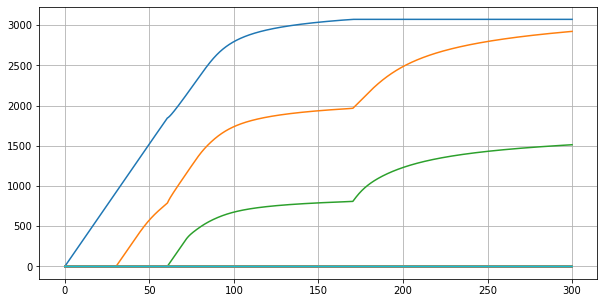

In [31]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(np.arange(stop=T+1 )/30, r[1, :, 2])
ax.grid(True)
T_end[1,2,0]

In [ ]:
v_on=np.zeros(N1)

v_off=np.zeros((N1,2))
v_on=L/(T_end[:,0,0]*dt)
v_on[3]=0
v_off[:,0]=(L-v_on*stop[1]*dt)/(dt*(T_end[:,1,0]-stop[1]))
v_off[:,1]=(L-v_on*stop[2]*dt)/(dt*(T_end[:,2,0]-stop[2]))

print("T_stop = "+str(stop[1]))
print("T_end when ON = "+str(T_end[:,0,0]))
print("T_end when OFF at "+str(stop[1])+" = "+str(T_end[:,1,0]))
print("T_end when OFF at "+str(stop[2])+" = "+str(T_end[:,2,0]))
print("v_on = "+str(v_on))
print("v_off at "+str(stop[1])+" = "+str(v_off[:,0]))
print("v_off at "+str(stop[2])+" = "+str(v_off[:,1]))


In [ ]:
fig = plt.figure(constrained_layout=True,figsize=(10,5))
gs = fig.add_gridspec(1,1)
ax4= fig.add_subplot(gs[0,0])

ax4.set_ylim(-2,36)
ax4.set_xlim(-0.001,0.132)
ax4.set_xlabel(r'$\alpha$ $\mathregular{(s^{-1})}$', fontsize=20)
ax4.set_ylabel(r'$V_{ON}$ (bp/s)', fontsize=20)
x=np.linspace(-0.1,1.1,100)
y=np.zeros(100)+30.5
ax4.plot(x,y,'--k')
#ax4.text(-0.04,0.94*45,'(a)',fontsize=12)
data_N=7
data=np.zeros((3,data_N))
#data[0]=np.array([0.02,0.03,0.04,0.05,0.1,0.2,1])
data[0]=[0.009,0.013,0.031,0.035,0.087,0.127,0.130
]
data[1]=np.array([21.59,26.96,28.00,29.25,31.46,30.35,30.28])  
data[2]=np.array([2.43261,0.974136,3.35517,2.51649,2.51609,1.56136,1.80873])
ax4.errorbar(data[0],data[1],yerr=data[2],color='red',fmt='o',ms=8,label='experiment')
ax4.plot(alpha[4:],v_on[4:],color='blue', marker='^', linestyle='solid',linewidth=2, markersize=8,label='simulation')
ax4.tick_params(axis='both', which='major', labelsize=15)
ax4.legend(loc="upper left",ncol=2,fontsize=15,frameon=False)

left, bottom, width, height = [0.24, 0.25, 0.2, 0.4]
ax1 = fig.add_axes([left, bottom, width, height])
left, bottom, width, height = [0.445, 0.25, 0.28, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
left, bottom, width, height = [0.73, 0.25, 0.25, 0.4]
ax3 = fig.add_axes([left, bottom, width, height])

w=0.24
ax1.set_ylim(0,35)
#ax1.get_yaxis().set_visible(False)
ax1.set_title('Low Initiation Rate', fontsize=14)
ax1.set_ylabel('Elongation Rate (bp/s)', fontsize=15)
#ax1.text(0.78,0.935*33,'(a)',fontsize=12)
x1=np.array([1,2])
y1=[21.0222,19.952]
err1=[2.16885,3.927]
z1=[v_on[0],v_off[0,1]]
ax1.bar(x1+0.17, z1, width=w, color='b', align='center', label='simulation')
ax1.bar(x1-0.17, y1, width=w, color='r', align='center',yerr=err1,label='experiment')
ax1.set_xticks(x1)
ax1.set_xticklabels([r'$V_{ON}$',r'$V_{OFF}$(90s)'], fontsize=14)
ax1.legend(loc="upper right",fontsize=13,frameon=False)
ax1.tick_params(axis='x', which='major', labelsize=14)
ax1.tick_params(axis='y', which='major', labelsize=12,rotation=90) 


w=0.3
ax2.set_title('Intermediate Initiation Rate', fontsize=14)
ax2.get_yaxis().set_visible(False)
ax2.set_ylim(0,35)
x2=np.array([1,2,3])
y2=[29.2473,11.546,7.047]
err2=[2.51649,2.273,2.807]
z2=[v_on[1],v_off[1,0],v_off[1,1]]
#ax2.text(0.57,0.935*33,'(b)',fontsize=12)
ax2.bar(x2+0.2, z2, width=w, color='b', align='center', label='simulation')
ax2.bar(x2-0.2, y2, width=w, color='r', align='center',yerr=err2,label='experiment')
ax2.set_xticks(x2)
ax2.set_xticklabels([r'$V_{ON}$',r'$V_{OFF}$(45s)',r'$V_{OFF}$(90s)'], fontsize=14)
ax2.legend(loc="upper right",fontsize=13,frameon=False)
ax2.tick_params(axis='x', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=12)

w=0.15
ax3.set_title('High Initiation Rate', fontsize=14)
ax3.set_ylim(0,35)
ax3.get_yaxis().set_visible(False)
x3=np.array([1,2])
y3=[30.35,5.789]
err3=[2.332401,3.17]
z3=[v_on[2],v_off[2,1]]
#ax3.text(0.78,0.935*33,'(c)',fontsize=12)
ax3.bar(x3+0.1, z3, width=w, color='b', align='center', label='simulation')
ax3.bar(x3-0.1, y3, width=w, color='r', align='center',yerr=err3,label='experiment')
ax3.set_xticks(x3)
ax3.set_xticklabels([r'$V_{ON}$',r'$V_{OFF}$(90s)'], fontsize=14)
ax3.legend(loc="best",fontsize=13,frameon=False)
ax3.tick_params(axis='x', which='major', labelsize=14)
ax3.tick_params(axis='y', which='major', labelsize=12)
plt.savefig('fig4.png', dpi=300, bbox_inches='tight')